In [1]:
from BaroSphere import BaroSphere
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
plt.style.use('dark_background')
B=BaroSphere(
    ntrunc=42,
    dt=1800,
    damping_order=4,
    efold=1*3600,
    nlat=128,
    do_tracers=1,
    ntracers=1,
    tracer_fix=False,
)

print(B.lons1.shape,B.lats1.shape)
print(B.ntracers)

# note - dt=1800 works well for up to T85
# 100 days at T85 takes 40 seconds

(256,) (128,)
1


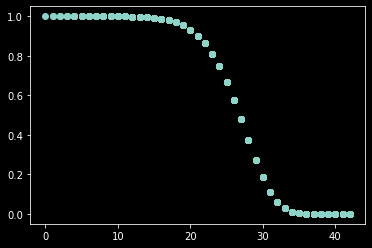

In [2]:
plt.plot(B.indxn,np.power(B.hyperdiff_fact,1*24*3600/B.dt),'o')
#plt.xlim([0,)
#plt.ylim([0.9,1])

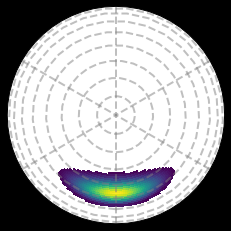

In [3]:
s=np.sin(B.lats*B.a)

S0 =np.exp( - np.power( (s - 0.7) / 0.1 ,2) )*np.exp( -((B.lons-180.)/30)**2 )

Sl=np.array([S0])

crs = ccrs.RotatedPole(pole_longitude=0, pole_latitude=0)
cproj=ccrs.Orthographic(-0, 0)
ax=plt.subplot(1,1,1,projection=cproj)
for S in Sl:
    temp = np.copy(S)
    temp[temp<1e-1]=np.nan
    ax.pcolormesh(B.lons,B.lats,temp,
            transform=crs,
            vmin=1e-1,vmax=1,alpha=1)
gl = ax.gridlines(crs=crs, draw_labels=False,
    linewidth=2, color='gray', alpha=0.5, linestyle='--')


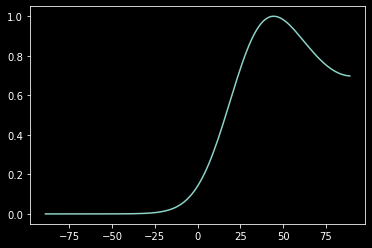

In [4]:
#grid space filter
damping_window=np.exp( - np.power( (s - 0.7) / 0.5,2) ) 
#damping_window=1-S0
#damping_window=s/s
plt.plot(B.lats1,damping_window[:,0])

In [5]:
#total number of steps to take
Nsteps = int(60*24*3600/B.dt)
#how often to take snapshots
dN_snap = int(6*3600/B.dt)
#total number of snapshots
Nsnaps = int(Nsteps/dN_snap)

print(Nsteps,dN_snap,Nsnaps)

#first time step 
# vrt0 = #0*B.vrtg_unstable_jet(m=12,A=8e-5) #initialiae with 0 
# __,tend_vrt = B.model_time_tendency(vrt0)
# vrt1 = vrt0 + B.dt * tend_vrt

B.vrtg_m1 = np.zeros([B.nlat,B.nlon])
B.vrtg = np.zeros([B.nlat,B.nlon])

#initialize the snapshots
vrt = np.zeros([Nsnaps+1,B.nlat,B.nlon])
tracers = np.zeros([Nsnaps+1,B.ntracers,B.nlat,B.nlon])
#vrt[0] = vrt0
ksnap = 1

#stocahstic realization decay time scale
tau=2*3600*24
#noise strength
NS=1.5e-10

#damping timescale for the mean drag
tdamp=10*24*3600

#spectral filter for the noise realization
B.w_indx_damp = np.ones(len(B.indxn))
B.w_indx_damp[B.indxm>15] = 0
B.w_indx_damp[B.indxm<6] = 0

#noise realization container
W = np.zeros(len(B.w_indx_damp))

tracer_damping = 5*24*3600
tracer_damping_f1 = np.exp(-B.dt/tracer_damping)
tracer_damping_f0 = (1-np.exp(-B.dt/tracer_damping))

#main time loop
for i in range(1,Nsteps+1):
    #timestep the model
    B.RA_leapfrog()
    #time step the noise realization
    W = (1-B.dt/tau) * W + NS*np.sqrt(B.dt / (2 * tau) )*np.random.randn(len(W))
    #add the noise to the model spectrally
    B.vrtg += B.x.spectogrd(B.w_indx_damp * W * B.dt) * damping_window    
    #apply mean "drag" to the model
    B.vrtg = B.vrtg * tdamp / (tdamp + B.dt)

    if i>=Nsteps//2:
        for n in range(0,B.ntracers):
            B.tracers[n] = Sl[n]*tracer_damping_f0 + B.tracers[n]*tracer_damping_f1

    #store data sometimes
    if i%dN_snap == 0:
        vrt[ksnap] = np.copy(B.vrtg)
        print(i,i*B.dt/3600/24,ksnap,np.max(vrt[ksnap]))
        if B.do_tracers:
            tracers[ksnap]=np.copy(B.tracers)
        ksnap += 1

2880 12 240
12 0.25 1 1.3484008256404073e-05
24 0.5 2 2.8900074600213035e-05
36 0.75 3 4.5468949416571e-05
48 1.0 4 6.673675806894744e-05
60 1.25 5 9.468541695521428e-05
72 1.5 6 0.00011427669975666518
84 1.75 7 0.00012579402574599408
96 2.0 8 0.00013181874373629533
108 2.25 9 0.0001223037007754657
120 2.5 10 0.00012671057495003925
132 2.75 11 0.000128777777067465
144 3.0 12 0.00014912435327987662
156 3.25 13 0.00017743996729814834
168 3.5 14 0.00018234631402917563
180 3.75 15 0.0001570250811887878
192 4.0 16 0.00016225565306207248
204 4.25 17 0.00017462232926562272
216 4.5 18 0.00018626135404138457
228 4.75 19 0.00020624047412446037
240 5.0 20 0.00023509835603641125
252 5.25 21 0.0002626039808046793
264 5.5 22 0.00028278804510026366
276 5.75 23 0.0002968080415392368
288 6.0 24 0.0002986916753302741
300 6.25 25 0.0003089223893479349
312 6.5 26 0.0003126565475411822
324 6.75 27 0.0003104906416887305
336 7.0 28 0.0003026149055597192
348 7.25 29 0.00029449064571123856
360 7.5 30 0.0002815

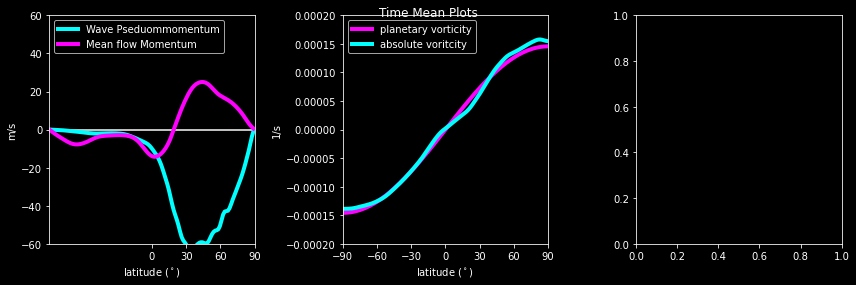

In [6]:
u,v=B.get_uv_vrtg(vrt[120:].mean(axis=0))

beta=B.omega*2*np.cos(np.pi/4)/B.rsphere

A=-np.power(vrt-vrt.mean(axis=-1)[:,:,np.newaxis],2)/(2*beta)
A=A[20:].mean(axis=0)

lw=4

plt.figure(0,figsize=(12,4))

plt.subplot(1,3,1)

plt.ylabel('m/s')
plt.xlabel('latitude ($^\\circ$)')
plt.xlim([-90,90])
plt.plot(B.lats1,0*B.lats1,'w')
plt.xticks(np.linspace(0,90,4))
plt.plot(B.lats1,A.mean(axis=-1),label='Wave Pseduommomentum',
linewidth=lw,color='cyan',alpha=1,linestyle='-')
plt.plot(B.lats1,u.mean(axis=-1),label='Mean flow Momentum',
linewidth=lw,color='magenta',alpha=1,linestyle='-')
plt.legend(loc=2)
plt.ylim([-60,60])

# plt.axvline(180/np.pi*np.arcsin(0.55),linestyle='--',color='green')
#plt.axvline(180/np.pi*np.arcsin(0.85),linestyle='--',color='green')

# plt.annotate('Stirring \nRegion',(15,-30),color='white')

#plt.gca().twinx()
#plt.plot(B.lats1,damping_window[:,0],'w--',label='Stirring Region')
#plt.ylabel('')

plt.legend(loc=2)

plt.subplot(1,3,2)

plt.ylabel('1/s')
plt.xlabel('latitude ($^\\circ$)')
plt.xticks(np.linspace(-90,90,7))
plt.plot(B.lats1,B.f.mean(axis=-1),
label='planetary vorticity',linewidth=lw,color='magenta')
plt.plot(B.lats1,B.f.mean(axis=-1)+vrt[20*4:].mean(axis=(0,-1)),
label='absolute voritcity',linewidth=lw,color='cyan')
# plt.axvline(180/np.pi*np.arcsin(0.55),linestyle='--',color='green')
# plt.axvline(180/np.pi*np.arcsin(0.85),linestyle='--',color='green')
plt.xlim([-90,90])
plt.ylim([-2.e-4,2.e-4])
plt.legend()

plt.subplot(1,3,3)




plt.suptitle('Time Mean Plots')

plt.tight_layout()

plt.savefig('TimeMean.png')

<Figure size 432x288 with 0 Axes>

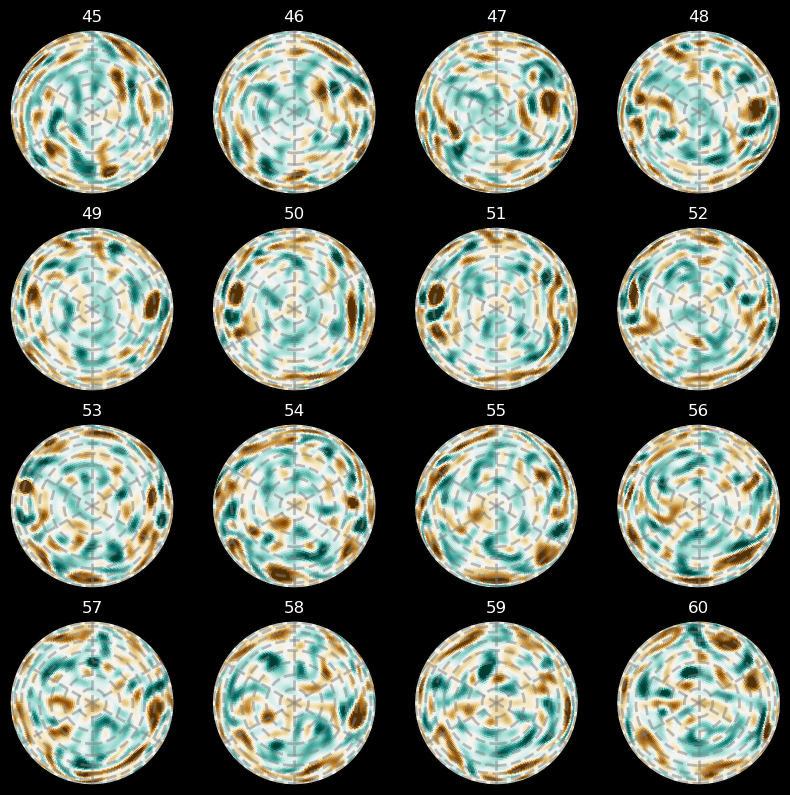

In [7]:

# look at some sample data to make sure things are working 
plt.clf()
plt.figure(0,figsize=(10,10),dpi=100)
lim=5e-5
crs = ccrs.RotatedPole(pole_longitude=0, pole_latitude=0)
cproj=ccrs.Orthographic(-0, 0)
cl=[plt.cm.Reds,plt.cm.Blues,plt.cm.Greens]
cl2=['red','green','blue']
nx=4; ny=4

def data_fill(x,y,f):
    xtemp = np.hstack([x,x[0]])
    ytemp = np.hstack([90,y])
    dtemp = np.concatenate([f,f[:,0][:,np.newaxis]],axis=1)
    dtemp = np.concatenate([f[0,:].mean(axis=0)*np.ones(len(x))[np.newaxis,:],f],axis=0)
    return xtemp,ytemp,dtemp

for i in range(0,16):
    ind=180+i*4
    ax=plt.subplot(4,4,i+1,projection=cproj)
    for i in range(0,1):
        xtemp,ytemp,dtemp = data_fill(B.lons1,B.lats1,vrt[ind])
        ax.pcolormesh(xtemp,ytemp,dtemp,
        vmax=1.e-4,vmin=-1.e-4,
        transform=crs,
        alpha=1,
        cmap=plt.cm.BrBG)    
    gl = ax.gridlines(crs=crs, draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#    gl.xlocator = FixedLocator([180,120])
    plt.title(int((dN_snap*B.dt*ind)/(3600*24)))


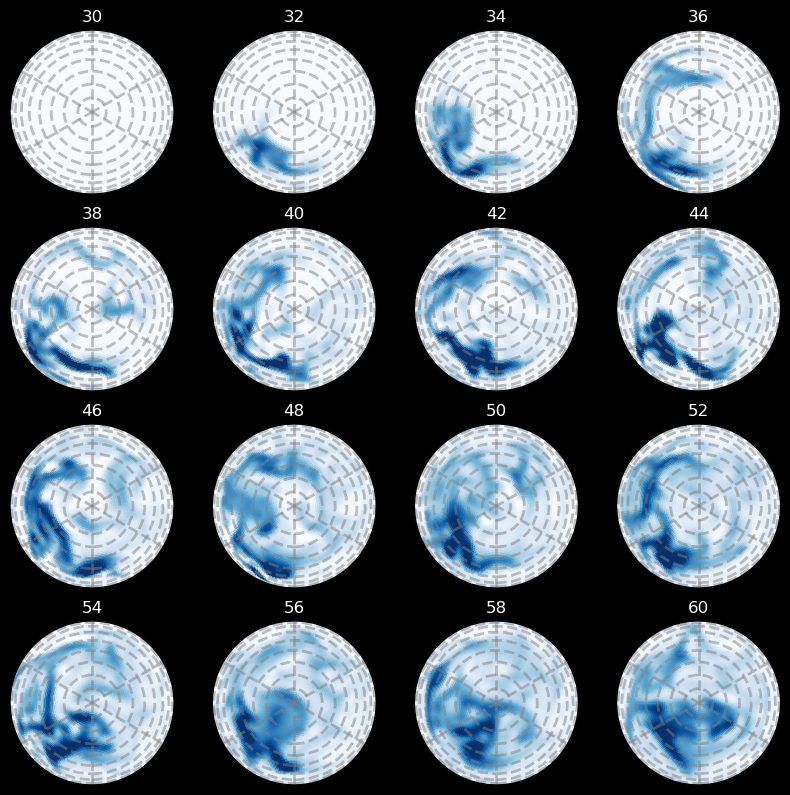

In [8]:
plt.figure(0,figsize=(10,10),dpi=100)
for i in range(0,16):
    ind=120+i*8
    ax=plt.subplot(4,4,i+1,projection=cproj)
    for i in range(0,1):
        xtemp,ytemp,dtemp = data_fill(B.lons1,B.lats1,tracers[ind,0])
        ax.pcolormesh(xtemp,ytemp,dtemp,
        vmax=1e-1,vmin=0,
        transform=crs,
        alpha=1,
        cmap=plt.cm.Blues)    
    gl = ax.gridlines(crs=crs, draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#    gl.xlocator = FixedLocator([180,120])
    plt.title(int((dN_snap*B.dt*ind)/(3600*24)))


In [9]:
# from matplotlib.ticker import FixedLocator
# plt.clf()
# plt.figure(0,figsize=(10,10),dpi=100)
# for i in range(0,120):
#     ind=120+i
#     ax=plt.subplot(1,1,1,projection=cproj)
#     xtemp,ytemp,dtemp = data_fill(B.lons1,B.lats1,tracers[ind,0])
#     ax.pcolormesh(xtemp,ytemp,dtemp,
#     vmax=1e-1,vmin=0,
#     transform=crs,
#     alpha=1,
#     cmap=plt.cm.Blues)    
#     ax.contour(B.lons1,B.lats1,S0,
#     levels=[0.5],
#     transform=crs,
#     alpha=0.5,
#     colors='k')    
#     gl = ax.gridlines(crs=crs, draw_labels=False,
#                 linewidth=2, color='gray', alpha=0.5, linestyle='--')
#     gl.ylocator = FixedLocator([30,55])
#     gl.xlines = False
#     plt.title(int((dN_snap*B.dt*ind)/(3600*24))-30)
#     plt.savefig('frames/T'+str(i).zfill(4)+'.png')



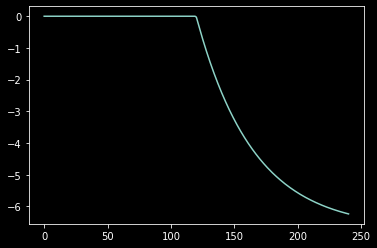

In [10]:
plt.plot( (B.ds[np.newaxis,:,:]*tracers[:,:]).sum(axis=(-1,-2)))